In [223]:
import numpy as np
import torch
from torch.autograd import Variable as V
import time
import torch.utils.data as Data
from torch import nn
from torch.nn import Module
from torch.nn import TransformerEncoderLayer
from torch.nn import TransformerEncoder
from torch.nn import TransformerDecoderLayer
from torch.nn import TransformerDecoder
from torch.nn import LayerNorm
from torch.nn import BatchNorm1d
from torch.nn import Linear
import torch.nn.functional as F
from torch.nn.functional import relu
from torch.nn import Dropout
from torch.nn.init import xavier_uniform_
import json
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from tqdm import tqdm
import matplotlib.pyplot as plt
import math

In [224]:
MAX_DEMAND = 723

In [225]:
# refered: https://pseudo-lab.github.io/Tutorial-Book/chapters/time-series/Ch3-preprocessing.html
def create_sequences(data, seq_length):
    x_seq = []
    y_seq = []
    temporal_embedding = []
    for i in range(len(data)-seq_length):
        x = data[i:(i+seq_length)]
        timestamp = []
        for t in range(i, i + seq_length):
            timestamp = [np.zeros(48) for _ in range(263)]
            for _ in range(263):
                timestamp[_][t % 48] = 1
        y = data[i+seq_length]
        temporal_embedding.append(timestamp)
        x_seq.append(x)
        y_seq.append(y)

    x = np.array(x_seq, dtype=np.float32)
    y = np.array(y_seq)
    for i in range(x.shape[0]):
        x[i] = x[i] / MAX_DEMAND
    # for i in range(y.shape[0]):
    #     y[i] = y[i] / MAX_DEMAND
    return x, y, np.array(temporal_embedding)

In [226]:
class CustomDataset(Dataset):
    def __init__(self, mode=None, seq_len=6, n_zones=263):
        data = np.load('Preprocessed_data/data.npy')

        data = create_sequences(data, seq_len)

        train_size = int(data[0].shape[0] * 0.8)
        if mode == "train":
            self.x_data, self.y_data, self.temporal_embedding = data[0][:int(train_size * 0.8)], data[1][:int(train_size * 0.8)], data[2][:int(train_size * 0.8)]
        elif mode == "valid":
            self.x_data, self.y_data, self.temporal_embedding = data[0][int(train_size * 0.8):train_size], data[1][int(train_size * 0.8):train_size], data[2][int(train_size * 0.8):train_size]
        else:
            self.x_data, self.y_data, self.temporal_embedding = data[0][train_size:], data[1][train_size:], data[2][train_size:]

        self.spatio_embedding = np.eye(n_zones)[[i for i in range(n_zones)]]

        

    def __len__(self):
        return self.x_data.shape[0]

    def __getitem__(self, idx):
        return self.x_data[idx], self.y_data[idx], self.spatio_embedding, self.temporal_embedding[idx]

In [227]:
# Refered: https://pytorch.org/tutorials/beginner/transformer_tutorial.html
class PositionalEncoding(nn.Module):

    def __init__(self, d_model, dropout=0.1, max_len=5000):
        super().__init__()
        self.dropout = nn.Dropout(p=dropout)

        position = torch.arange(max_len).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2) * (-math.log(10000.0) / d_model))
        pe = torch.zeros(max_len, 1, d_model)
        pe[:, 0, 0::2] = torch.sin(position * div_term)
        pe[:, 0, 1::2] = torch.cos(position * div_term)
        self.register_buffer('pe', pe)

    def forward(self, x):
        """
        Args:
            x: Tensor, shape [seq_len, batch_size, embedding_dim]
        """
        x = x + self.pe[:x.size(0)]
        return self.dropout(x)

In [228]:
class DemandPrediction(Module):

    def __init__(self, n_zones=263, seq_len=6, n_encoders=1) -> None:
        super(DemandPrediction, self).__init__()

        self.DIMENSION = 32
        self.NUM_ENCODERS = n_encoders

        self.spatial_embedding_layer = Linear(n_zones, self.DIMENSION)
        self.temporal_embedding_layer = Linear(48, self.DIMENSION)

        self.extract_feature = nn.Conv1d(in_channels=n_zones, out_channels=n_zones, kernel_size=3, stride=1, padding=1)
        self.demand_embedding_layer = nn.Linear(seq_len, self.DIMENSION)

        self.infomation_embedding_layer = Linear(self.DIMENSION, self.DIMENSION)

        encoder_layer = TransformerEncoderLayer(d_model=self.DIMENSION, nhead=4, dim_feedforward=64, dropout=0.1)
        encoder_norm = LayerNorm(self.DIMENSION)
        self.encoder = TransformerEncoder(encoder_layer=encoder_layer, num_layers=2, norm=encoder_norm)

        self.linear = Linear(self.DIMENSION, self.DIMENSION)
        self.norm = LayerNorm(self.DIMENSION)

        # decoder_layer = TransformerDecoderLayer(d_model=self.DIMENSION, nhead=8, dim_feedforward=128, dropout=0.1)
        # decoder_norm = LayerNorm(self.DIMENSION)
        # self.decoder = TransformerDecoder(decoder_layer=decoder_layer, num_layers=1, norm=decoder_norm)

        self.flatten = nn.Flatten(start_dim=1, end_dim=-1)

        # self.get_feature = Linear(256, 512)
        self.get_feature = Linear(self.DIMENSION, 1)
        self.dropout_layer = nn.Dropout(p=0.1)
        self.get_prediction = Linear(16, 1)
    
    def forward(self, x, spatio_embedding, temporal_embedding):

        # print(spatio_embedding.shape, temporal_embedding.shape)

        spatio_embedding = relu(self.spatial_embedding_layer(spatio_embedding))
        temporal_embedding = relu(self.temporal_embedding_layer(temporal_embedding))

        demand_embedding = self.extract_feature(x.transpose(2, 1))
        demand_embedding = relu(self.demand_embedding_layer(demand_embedding))

        # print(spatio_embedding.shape, temporal_embedding.shape, demand_embedding.shape)
        infomation_fusion = self.infomation_embedding_layer(spatio_embedding + temporal_embedding + demand_embedding)
        infomation_fusion = self.encoder(infomation_fusion)

        # infomation_fusion = self.decoder(infomation_fusion, x)
        # x = self.flatten(infomation_fusion)
        # x = self.dropout_layer(infomation_fusion)
        x = relu(self.get_feature(infomation_fusion))
        # x = self.dropout_layer(x)
        # x = relu(self.get_prediction(x))
        return x


In [229]:
NUM_EPOCHS = 500
BATCH_SIZE = 16
LEARNING_RATE = 1e-3
SEQ_LEN = 6
LR_SCHEDULER = 10

In [230]:
dataset = CustomDataset("train", seq_len=SEQ_LEN)
data_loader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True)
validset = CustomDataset("valid", seq_len=SEQ_LEN)
valid_loader = DataLoader(validset, batch_size=BATCH_SIZE, shuffle=True)
testset = CustomDataset(mode="test", seq_len=SEQ_LEN)
test_loader = DataLoader(testset)

In [231]:
model = DemandPrediction(seq_len=SEQ_LEN).cuda()
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr = LEARNING_RATE)

In [232]:
losses = []
valids = []
best_valid_loss = 1e9 + 7
patience = 0
threshold = 50
best_model = model.state_dict()
for epoch in range(NUM_EPOCHS):
    avg_train_loss, avg_valid_loss = 0, 0

    if epoch >= 10 and epoch % 10 == 0:
        LEARNING_RATE *= 0.9
        optimizer = torch.optim.Adam(model.parameters(), lr = LEARNING_RATE)

    model.train()
    for batch_idx, samples in enumerate(data_loader):
        optimizer.zero_grad()
        x, y_true, spatio_embedding, temporal_embedding = samples
        y_pred = model(x.float().cuda(), spatio_embedding.float().cuda(), temporal_embedding.float().cuda())
        # print(y_pred.shape, y_true.shape)
        loss = torch.sqrt(criterion(y_pred.squeeze(2), y_true.float().cuda()))
        loss.backward()
        optimizer.step()
        avg_train_loss += loss.item()
    #     break
    # break

    model.eval()
    with torch.no_grad():
        for batch_idx, samples in enumerate(valid_loader):
            optimizer.zero_grad()
            x, y_true, spatio_embedding, temporal_embedding = samples
            y_pred = model(x.float().cuda(), spatio_embedding.float().cuda(), temporal_embedding.float().cuda())
            loss = torch.sqrt(criterion(y_pred.squeeze(2), y_true.float().cuda()))
            avg_valid_loss += loss.item()

    avg_train_loss /= len(data_loader)
    avg_valid_loss /= len(valid_loader)

    if avg_valid_loss < best_valid_loss:
        best_valid_loss = avg_valid_loss
        patience = 0
        best_model = model.state_dict()
    else:
        patience += 1
        if patience > threshold:
            print(f"Early stopping! More than {threshold} epochs that the valid loss does not improve!")
            torch.save(best_model, "best_model.pt")
            break

    losses.append(avg_train_loss)
    valids.append(avg_valid_loss)


    print(f"Epoch {epoch + 1}  train_loss: {avg_train_loss:.6f}      valid_loss: {avg_valid_loss:.6f}")

Epoch 1  train_loss: 57.036111      valid_loss: 57.831057
Epoch 2  train_loss: 57.028779      valid_loss: 58.144006
Epoch 3  train_loss: 56.972071      valid_loss: 57.750517
Epoch 4  train_loss: 56.989803      valid_loss: 58.238390
Epoch 5  train_loss: 56.979483      valid_loss: 57.828695
Epoch 6  train_loss: 57.012186      valid_loss: 57.971788
Epoch 7  train_loss: 57.009833      valid_loss: 58.575215
Epoch 8  train_loss: 56.962433      valid_loss: 57.944396
Epoch 9  train_loss: 56.992766      valid_loss: 58.305967
Epoch 10  train_loss: 56.983976      valid_loss: 58.243541
Epoch 11  train_loss: 56.994841      valid_loss: 57.945193
Epoch 12  train_loss: 57.020802      valid_loss: 58.423357
Epoch 13  train_loss: 57.019868      valid_loss: 58.353022
Epoch 14  train_loss: 56.970128      valid_loss: 58.169665
Epoch 15  train_loss: 56.990852      valid_loss: 57.962743
Epoch 16  train_loss: 57.046366      valid_loss: 57.624158
Epoch 17  train_loss: 57.012674      valid_loss: 57.796592
Epoch 

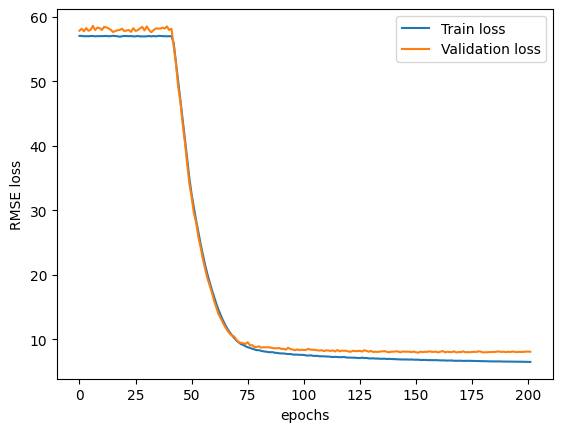

In [233]:
plt.plot(losses, label="Train loss")
plt.plot(valids, label="Validation loss")
plt.xlabel("epochs")
plt.ylabel("RMSE loss")
plt.legend(loc="upper right")

In [234]:
model = DemandPrediction(seq_len=SEQ_LEN).cuda()
model.load_state_dict(torch.load("best_model.pt"))

<All keys matched successfully>

In [235]:
avg_loss = 0
model.eval()
with torch.no_grad():
    for batch_idx, samples in enumerate(test_loader):
        optimizer.zero_grad()
        x, y_true, spatio_embedding, temporal_embedding = samples
        y_pred = model(x.float().cuda(), spatio_embedding.float().cuda(), temporal_embedding.float().cuda())
        loss = torch.sqrt(criterion(y_pred.squeeze(2), y_true.float().cuda()))
        avg_loss += loss.item()

print(f"Test RMSE: {avg_loss / len(test_loader):.6f}")

Test RMSE: 7.092931


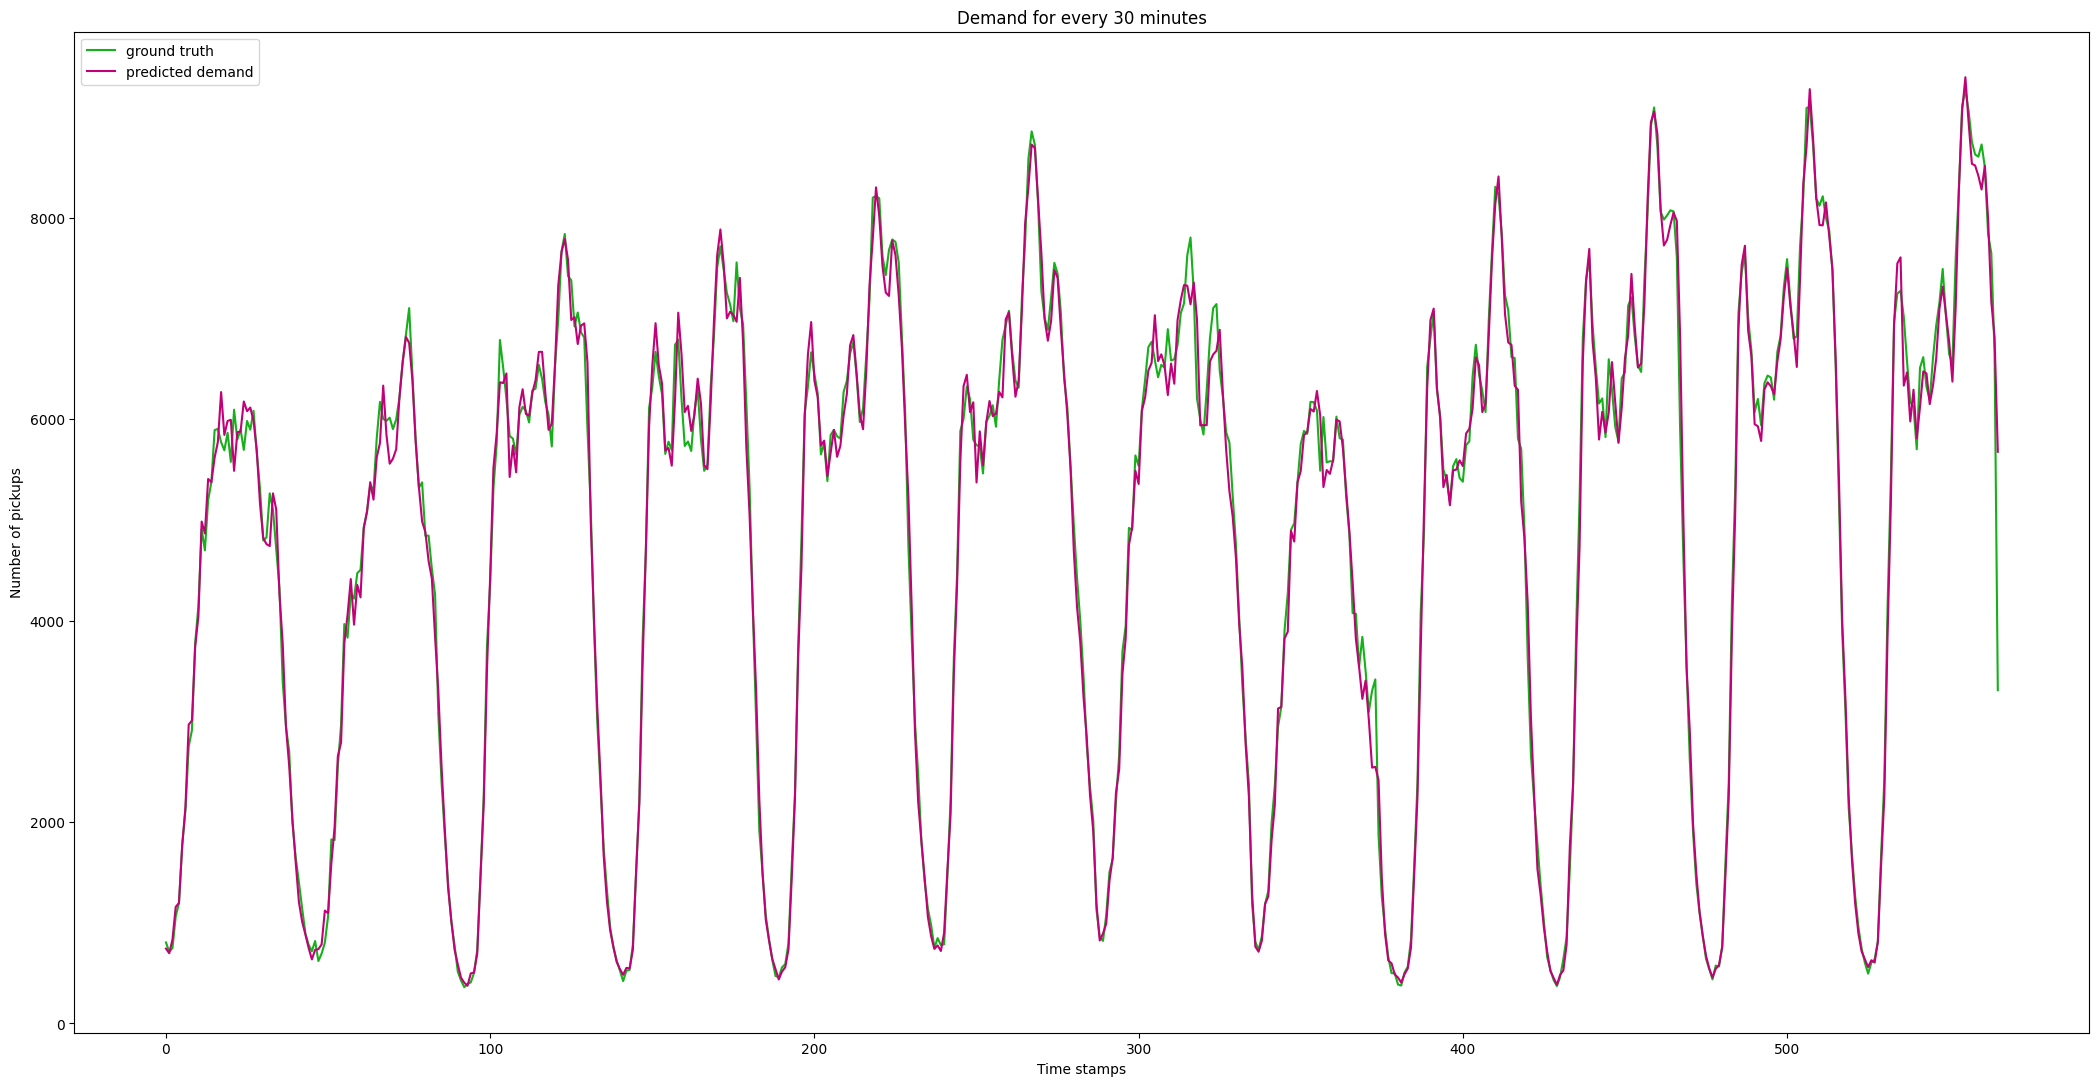

In [236]:
ground_truth = []
predicted_demand = []
model.eval()
with torch.no_grad():
    for batch_idx, samples in enumerate(test_loader):
        optimizer.zero_grad()
        x, y_true, spatio_embedding, temporal_embedding = samples
        y_pred = model(x.float().cuda(), spatio_embedding.float().cuda(), temporal_embedding.float().cuda())
        predicted_demand.append(y_pred.squeeze(2).cpu().sum())
        ground_truth.append(y_true.sum())

plt.figure(figsize=(26,13))

timestamps = [s for s in range(0,len(test_loader))]
plt.plot(timestamps,ground_truth,'xkcd:green',label = 'ground truth')
plt.plot(timestamps,predicted_demand,'xkcd:magenta',label = 'predicted demand')

plt.xlabel('Time stamps')
plt.ylabel('Number of pickups')
plt.title('Demand for every 30 minutes')
plt.legend()
plt.show()

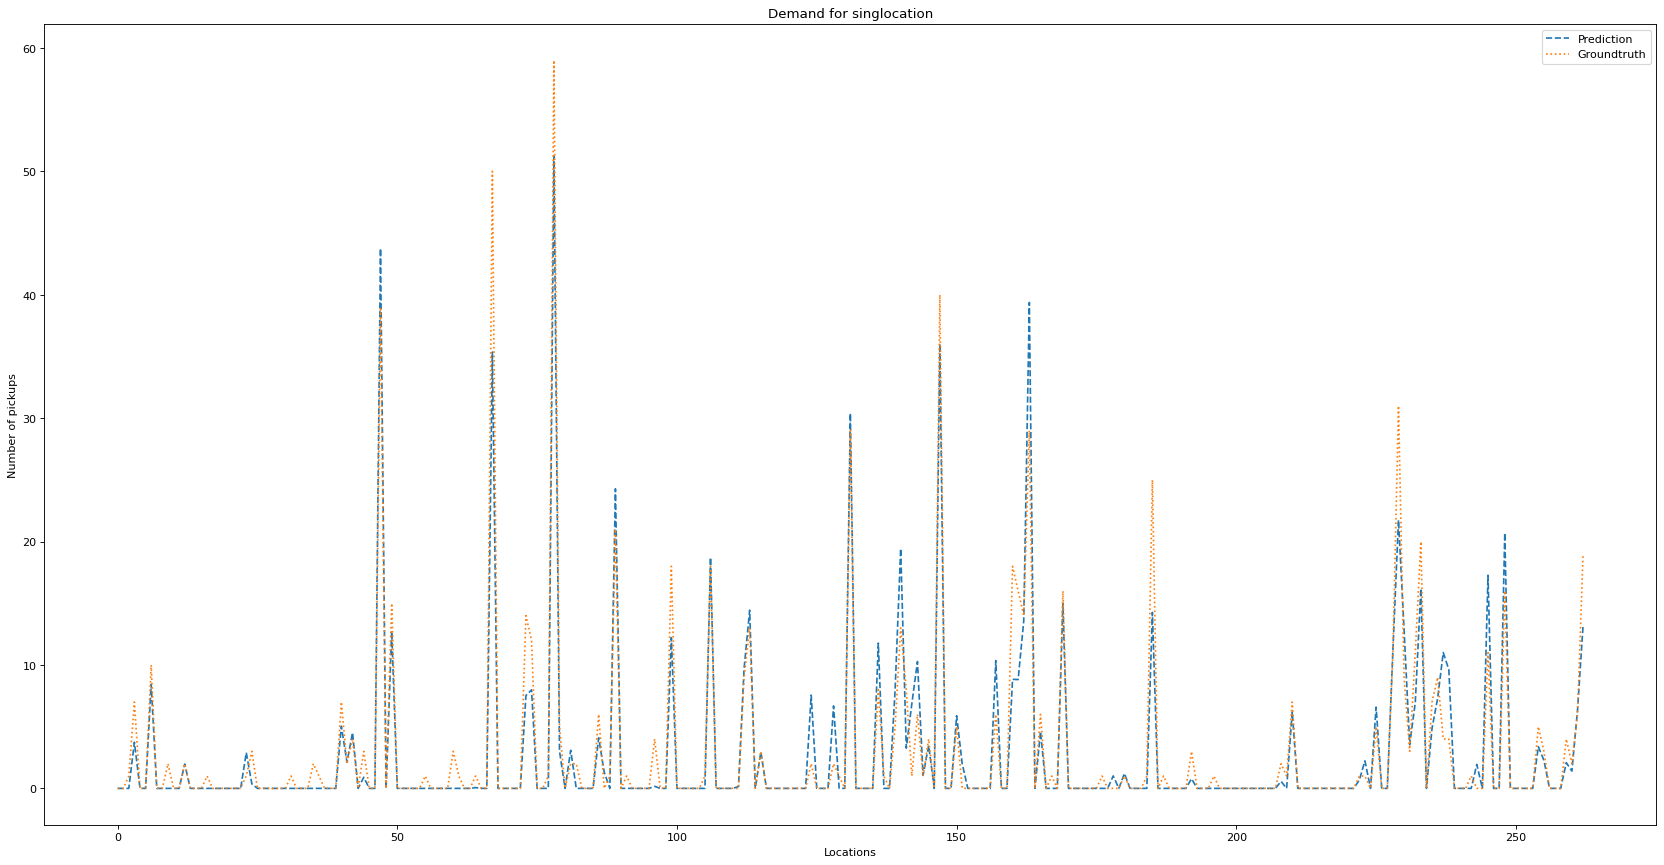

In [237]:
from matplotlib.pyplot import figure

figure(figsize=(26, 13), dpi=80)

model.eval()
with torch.no_grad():
    for batch_idx, samples in enumerate(test_loader):
        x, y_true, spatio_embedding, temporal_embedding = samples
        y_pred = model(x.float().cuda(), spatio_embedding.float().cuda(), temporal_embedding.float().cuda())
        plt.plot(y_pred.squeeze(2)[0].cpu().detach().numpy(), '--', label = 'Prediction')
        plt.plot(y_true[0], ':', label = 'Groundtruth')

        plt.xlabel('Locations')
        plt.ylabel('Number of pickups')
        plt.title('Demand for singlocation')
        plt.legend()
        break

In [240]:
import shapefile
from shapely.geometry import Polygon
from descartes.patch import PolygonPatch
import matplotlib as mpl
import matplotlib.pyplot as plt

In [312]:
# https://chih-ling-hsu.github.io/2018/05/14/NYC 

def get_boundaries(sf):
    lat, lon = [], []
    for shape in list(sf.iterShapes()):
        lat.extend([shape.bbox[0], shape.bbox[2]])
        lon.extend([shape.bbox[1], shape.bbox[3]])

    margin = 0.01 # buffer to add to the range
    lat_min = min(lat) - margin
    lat_max = max(lat) + margin
    lon_min = min(lon) - margin
    lon_max = max(lon) + margin

    return lat_min, lat_max, lon_min, lon_max


def draw_region_map(ax, sf, heat={}):
    continent = [235/256, 151/256, 78/256]
    ocean = (89/256, 171/256, 227/256)    
    
    reg_list={'Staten Island':1, 'Queens':2, 'Bronx':3, 'Manhattan':4, 'EWR':5, 'Brooklyn':6}
    reg_x = {'Staten Island':[], 'Queens':[], 'Bronx':[], 'Manhattan':[], 'EWR':[], 'Brooklyn':[]}
    reg_y = {'Staten Island':[], 'Queens':[], 'Bronx':[], 'Manhattan':[], 'EWR':[], 'Brooklyn':[]}
    
    # colorbar
    if len(heat) != 0:
        norm = mpl.colors.Normalize(vmin=math.sqrt(min(heat.values())), vmax=math.sqrt(max(heat.values()))) #norm = mpl.colors.LogNorm(vmin=1,vmax=max(heat))
        cm=plt.get_cmap('Reds')
        #sm = plt.cm.ScalarMappable(cmap=cm, norm=norm)
        #sm.set_array([])
        #plt.colorbar(sm, ticks=np.linspace(min(heat.values()),max(heat.values()),8), \
        #             boundaries=np.arange(min(heat.values())-10,max(heat.values())+10,.1))
    
    ax.set_facecolor(ocean)
    for sr in sf.shapeRecords():
        shape = sr.shape
        rec = sr.record
        reg_name = rec[shp_dic['borough']]
        
        if len(heat) == 0:
            norm = mpl.colors.Normalize(vmin=1,vmax=6) #norm = mpl.colors.LogNorm(vmin=1,vmax=max(heat))
            cm=plt.get_cmap('Pastel1')
            R,G,B,A = cm(norm(reg_list[reg_name]))
            col = [R,G,B]
        else:
            R,G,B,A = cm(norm(math.sqrt(heat[reg_name])))
            col = [R,G,B]
            
        # check number of parts (could use MultiPolygon class of shapely?)
        nparts = len(shape.parts) # total parts
        if nparts == 1:
            polygon = Polygon(shape.points)
            patch = PolygonPatch(polygon, facecolor=col, alpha=1.0, zorder=2)
            ax.add_patch(patch)
        else: # loop over parts of each shape, plot separately
            for ip in range(nparts): # loop over parts, plot separately
                i0 = shape.parts[ip]
                if ip < nparts-1:
                    i1 = shape.parts[ip+1]-1
                else:
                    i1 = len(shape.points)

                polygon = Polygon(shape.points[i0:i1+1])
                patch = PolygonPatch(polygon, facecolor=col, alpha=1.0, zorder=2)
                ax.add_patch(patch)
                
        reg_x[reg_name].append((shape.bbox[0]+shape.bbox[2])/2)
        reg_y[reg_name].append((shape.bbox[1]+shape.bbox[3])/2)
        
    for k in reg_list:
        if len(heat)==0:
            plt.text(np.mean(reg_x[k]), np.mean(reg_y[k]), k, horizontalalignment='center', verticalalignment='center',
                        bbox=dict(facecolor='black', alpha=0.5), color="white", fontsize=12)     
        else:
            plt.text(np.mean(reg_x[k]), np.mean(reg_y[k]), "{}\n({}K)".format(k, heat[k]/1000), horizontalalignment='center', 
                     verticalalignment='center',bbox=dict(facecolor='black', alpha=0.5), color="white", fontsize=12)       

    # display
    limits = get_boundaries(sf)
    plt.xlim(limits[0], limits[1])
    plt.ylim(limits[2], limits[3])


def draw_zone_map(ax, sf, heat={}, text=[], arrows=[]):
    continent = [235/256, 151/256, 78/256]
    ocean = (89/256, 171/256, 227/256)
    theta = np.linspace(0, 2*np.pi, len(text)+1).tolist()
    ax.set_facecolor(ocean)
    
    # colorbar
    if len(heat) != 0:
        norm = mpl.colors.Normalize(vmin=min(heat.values()),vmax=max(heat.values())) #norm = mpl.colors.LogNorm(vmin=1,vmax=max(heat))
        cm=plt.get_cmap('Reds')
        sm = plt.cm.ScalarMappable(cmap=cm, norm=norm)
        sm.set_array([])
        plt.colorbar(sm, ticks=np.linspace(0,59,8),
                     boundaries=np.arange(0-10,59+10,.1))
    
    for sr in sf.shapeRecords():
        shape = sr.shape
        rec = sr.record
        loc_id = rec[shp_dic['location_i']]
        zone = rec[shp_dic['zone']]
        
        if len(heat) == 0:
            col = continent
        else:
            if loc_id not in heat:
                R,G,B,A = cm(norm(0))
            else:
                R,G,B,A = cm(norm(heat[loc_id]))
            col = [R,G,B]

        # check number of parts (could use MultiPolygon class of shapely?)
        nparts = len(shape.parts) # total parts
        if nparts == 1:
            polygon = Polygon(shape.points)
            patch = PolygonPatch(polygon, facecolor=col, alpha=1.0, zorder=2)
            ax.add_patch(patch)
        else: # loop over parts of each shape, plot separately
            for ip in range(nparts): # loop over parts, plot separately
                i0 = shape.parts[ip]
                if ip < nparts-1:
                    i1 = shape.parts[ip+1]-1
                else:
                    i1 = len(shape.points)

                polygon = Polygon(shape.points[i0:i1+1])
                patch = PolygonPatch(polygon, facecolor=col, alpha=1.0, zorder=2)
                ax.add_patch(patch)
        
        x = (shape.bbox[0]+shape.bbox[2])/2
        y = (shape.bbox[1]+shape.bbox[3])/2

    if len(arrows)!=0:
        for arr in arrows:
            ax.annotate('', xy = arr['dest'], xytext = arr['src'], size = arr['cnt'],
                    arrowprops=dict(arrowstyle="fancy", fc="0.6", ec="none"))
    
    # display
    limits = get_boundaries(sf)
    plt.xlim(limits[0], limits[1])
    plt.ylim(limits[2], limits[3])

In [317]:
pred_heatmap = {}
true_heatmap = {}
error_heatmap = {}
pred_total = {}
true_total = {}

t_pred = np.array([0 for i in range(263)], dtype=np.float32)
t_true = np.array([0 for i in range(263)])

model.eval()
with torch.no_grad():
    for batch_idx, samples in enumerate(test_loader):
        x, y_true, spatio_embedding, temporal_embedding = samples
        y_pred = model(x.float().cuda(), spatio_embedding.float().cuda(), temporal_embedding.float().cuda())
        error = np.abs(y_pred.squeeze(2)[0].cpu().detach().numpy() - y_true[0].detach().numpy())
        # t_pred += y_pred.squeeze(2)[0].cpu().detach().numpy()
        # t_true += y_true[0].detach().numpy()
        # print(y_true[0][132])
        pred_heatmap = dict(enumerate(np.append(np.array([0.0]), y_pred.squeeze(2)[0].cpu().detach().numpy())))
        true_heatmap = dict(enumerate(np.append(np.array([0]), y_true[0].detach().numpy())))
        error = np.abs(y_pred.squeeze(2)[0].cpu().detach().numpy() - y_true[0].detach().numpy())
        error_heatmap = dict(enumerate(np.append(np.array([0]), error)))
        break
# pred_total = dict(enumerate(np.append(np.array([0.0]), t_pred)))
# true_total = dict(enumerate(np.append(np.array([0]), t_true)))

In [314]:
sf = shapefile.Reader("Preprocessed_data/taxi_zones/taxi_zones.shp")
fields_name = [field[0] for field in sf.fields[1:]]
shp_dic = dict(zip(fields_name, list(range(len(fields_name)))))
attributes = sf.records()
shp_attr = [dict(zip(fields_name, attr)) for attr in attributes]

/tmp/ipykernel_26974/3445170780.py:97: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  plt.colorbar(sm, ticks=np.linspace(min(heat.values()),max(heat.values()),8),
/mnt/d/kurone/UNIST/5thSemester/Deep_Learning/venv/lib/python3.8/site-packages/descartes/patch.py:62: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  vertices = concatenate([


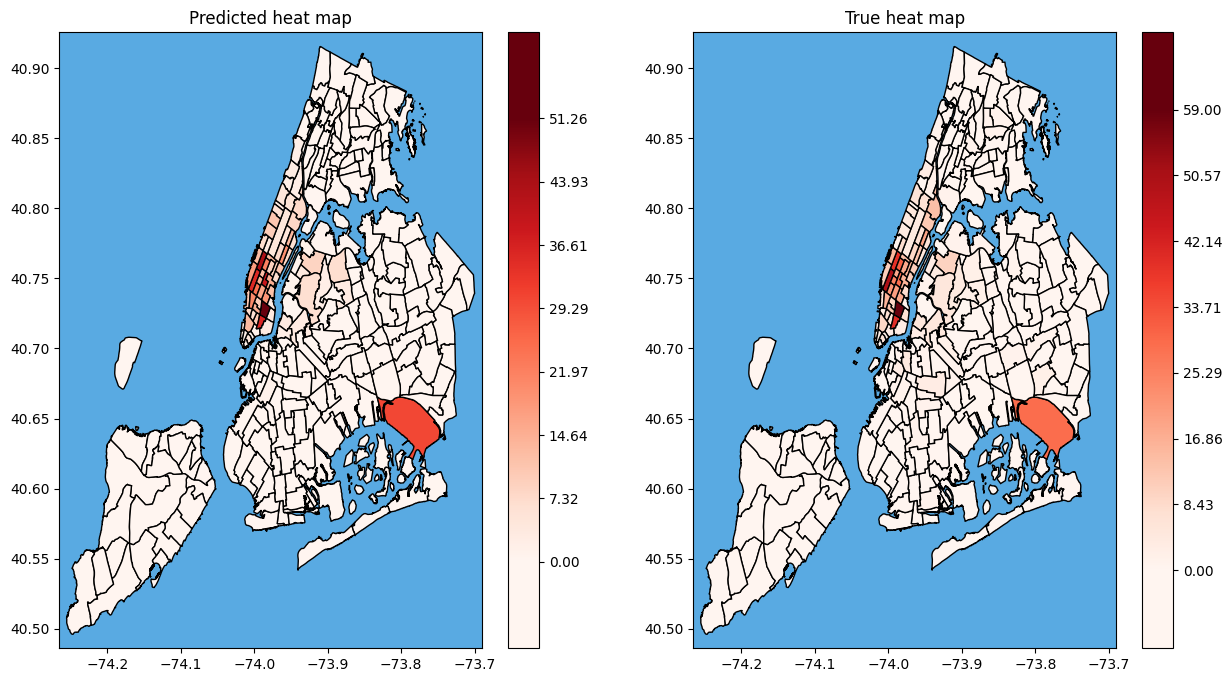

In [318]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15,8))
ax = plt.subplot(1, 2, 1)
ax.set_title("Predicted heat map")
draw_zone_map(ax, sf, pred_heatmap)
ax = plt.subplot(1, 2, 2)
ax.set_title("True heat map")
draw_zone_map(ax, sf, true_heatmap)

/tmp/ipykernel_26974/861339281.py:2: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1, 2, 1)
/tmp/ipykernel_26974/3445170780.py:97: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  plt.colorbar(sm, ticks=np.linspace(min(heat.values()),max(heat.values()),8),


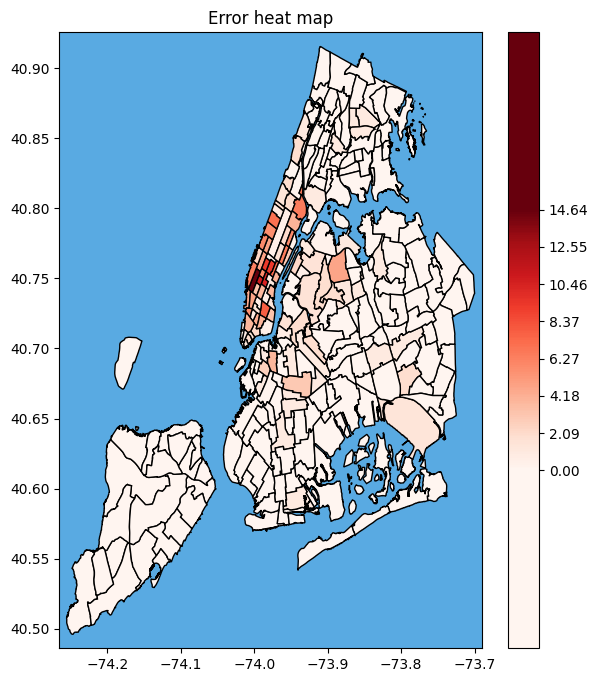

In [320]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(15,8))
ax = plt.subplot(1, 2, 1)
ax.set_title("Error heat map")
draw_zone_map(ax, sf, error_heatmap)

/tmp/ipykernel_26974/3445170780.py:97: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  plt.colorbar(sm, ticks=np.linspace(min(heat.values()),max(heat.values()),8),


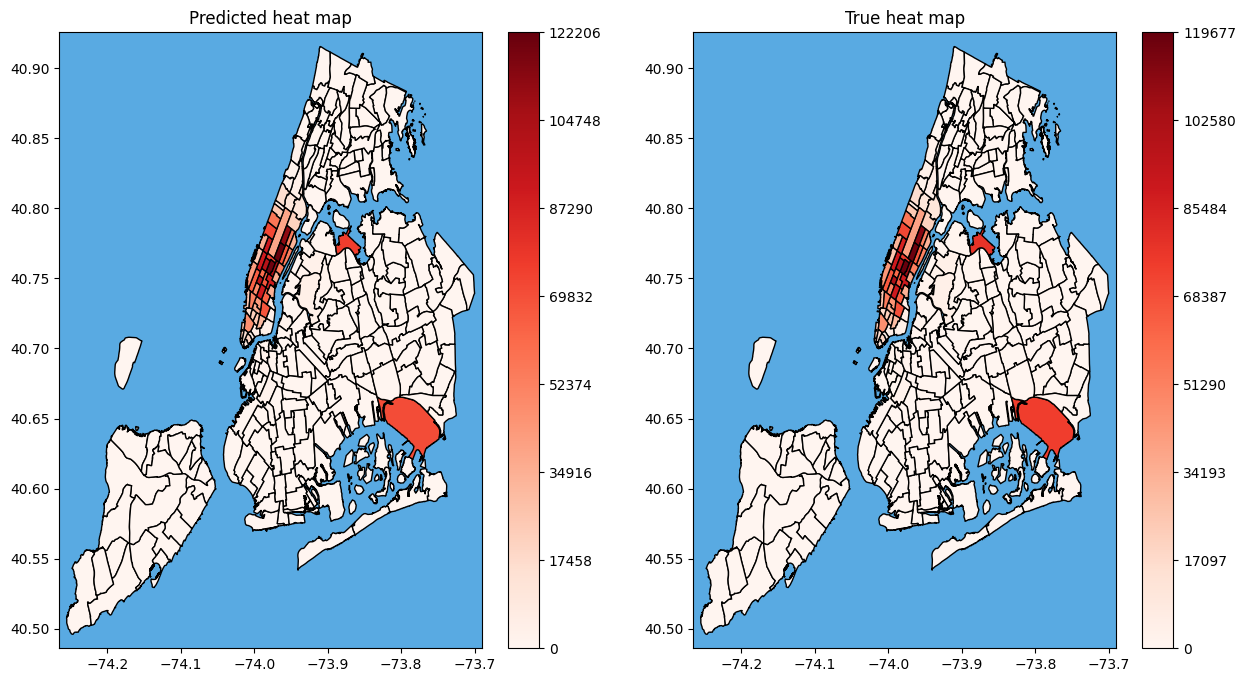

In [316]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15,8))
ax = plt.subplot(1, 2, 1)
ax.set_title("Predicted heat map")
draw_zone_map(ax, sf, pred_total)
ax = plt.subplot(1, 2, 2)
ax.set_title("True heat map")
draw_zone_map(ax, sf, true_total)